In [27]:
# install required packages 
!pip install lxml matplotlib seaborn 
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\MSI\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [40]:
from io import StringIO
#  Data Acquisition 
# headers for easy access
headers = {'User-Agent': 'Mozilla/5.0'}
url = "https://en.wikipedia.org/wiki/AFI%27s_100_Years...100_Movies"
page = requests.get(url, headers=headers)

# Data Cleaning
def clean_text(text):
    """Advanced cleaning using regex"""
    if pd.isna(text): # handle missing values
        return text
    text = str(text)  # input is treated as a string
    text = re.sub(r'\[\d+\]', '', text)  # Remove citations [1]
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    text = re.sub(r'\([^)]*\)', '', text)  # Remove parentheses content
    return text

#  Data Processing
def process_data(page):
    soup = BeautifulSoup(page.content, 'lxml')   # uses lxml for speed
    table = soup.find('table', {'class': 'wikitable'})
    df = pd.read_html(StringIO(str(table)))[0] # Convert to DataFrame and return the first table (StringIO to preserve pd.read_html) 
    
     # Clean all columns and standardize all texts 
    df = df.map(clean_text)
    
# Convert year to numeric and handle special cases
    df['Release year'] = df['Release year'].str.extract(r'(\d{4})')[0].astype(int)
    
    return df
    
# convert raw HTML content into a data frame
df = process_data(page)

# Handle duplicate movies 
df = df.drop_duplicates(subset=['Film'])


In [29]:
#  Save Cleaned Data in csv file 
with open('afi_top_100_cleaned.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # Write column headers 
    writer.writerow(['Film', 'Release year', 'Director', 'Production companies', '1998 Rank', '2007 Rank'])
    
     # Write data rows
    for _, row in df.iterrows():   #Iterate through each dataframe row
        writer.writerow([
            row['Film'],
            row['Release year'],
            row['Director'],
            row.get('Production companies', 'N/A'),  # Using get() for optional columns (returns N/A default value if the column doesn't exist)
            row.get('1998 Rank', 'N/A'),
            row.get('2007 Rank', 'N/A')
        ])

print("\n=== Cleaned Data Sample ===")
print(df[['Film', 'Release year', 'Director', 'Production companies', '1998 Rank', '2007 Rank']].head())
print("\nData saved to afi_top_100_cleaned.csv")


=== Cleaned Data Sample ===
                 Film  Release year              Director  \
0        Citizen Kane          1941          Orson Welles   
1          Casablanca          1942        Michael Curtiz   
2       The Godfather          1972  Francis Ford Coppola   
3  Gone with the Wind          1939        Victor Fleming   
4  Lawrence of Arabia          1962            David Lean   

                     Production companies 1998 Rank 2007 Rank  
0                      RKO Radio Pictures         1         1  
1                   Warner Bros. Pictures         2         3  
2  Paramount Pictures, Alfran Productions         3         2  
3         Selznick International Pictures         4         6  
4                        Horizon Pictures         5         7  

Data saved to afi_top_100_cleaned.csv


In [30]:
#  Data Analysis 
print("\n=== Basic Statistics ===")

#  earliest and latest film release years
print(f"Time Range: {df['Release year'].min()} - {df['Release year'].max()}")

# show the director who appears most often in the list
print(f"Most Frequent Director: {df['Director'].mode()[0]}")

print("\nTop 5 Directors:")
print(df['Director'].value_counts().head(5)) # show the top 5 directors with most films


=== Basic Statistics ===
Time Range: 1915 - 2001
Most Frequent Director: Steven Spielberg

Top 5 Directors:
Director
Steven Spielberg    6
Billy Wilder        4
Stanley Kubrick     4
George Stevens      4
Alfred Hitchcock    4
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '1910'),
  Text(1, 0, '1920'),
  Text(2, 0, '1930'),
  Text(3, 0, '1940'),
  Text(4, 0, '1950'),
  Text(5, 0, '1960'),
  Text(6, 0, '1970'),
  Text(7, 0, '1980'),
  Text(8, 0, '1990'),
  Text(9, 0, '2000')])

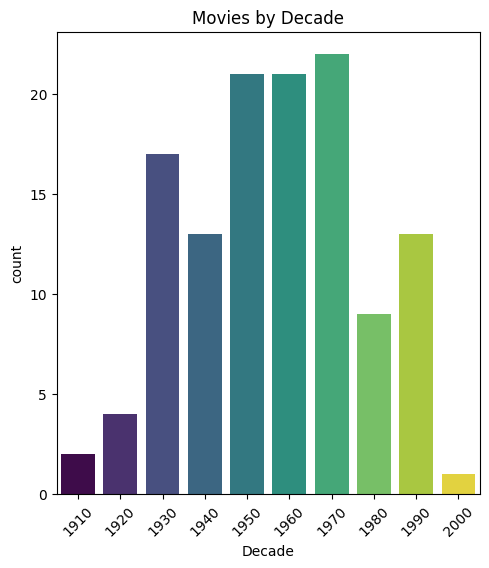

In [38]:
#  Visualization
# 1. Movies by Decade (bar chart)
plt.figure(figsize=(12, 6))

# Convert years to decades and show how many movies exist per decade
df['Decade'] = (df['Release year'] // 10) * 10   
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Decade', hue='Decade', palette='viridis', legend=False)  
plt.title('Movies by Decade')
plt.xticks(rotation=45)


Visualizations saved to 'movie_analysis.png'


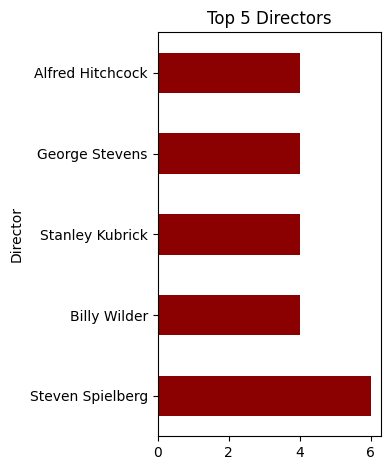

In [32]:
# 2. Top Directors 
plt.subplot(1, 2, 2)

# Count how many films each director has and take the top 5
df['Director'].value_counts().head(5).plot(kind='barh', color='darkred')  
plt.title('Top 5 Directors')
plt.tight_layout()
plt.savefig('movie_analysis.png', dpi=300)
print("\nVisualizations saved to 'movie_analysis.png'")

In [33]:
!pip install wordcloud


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\MSI\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


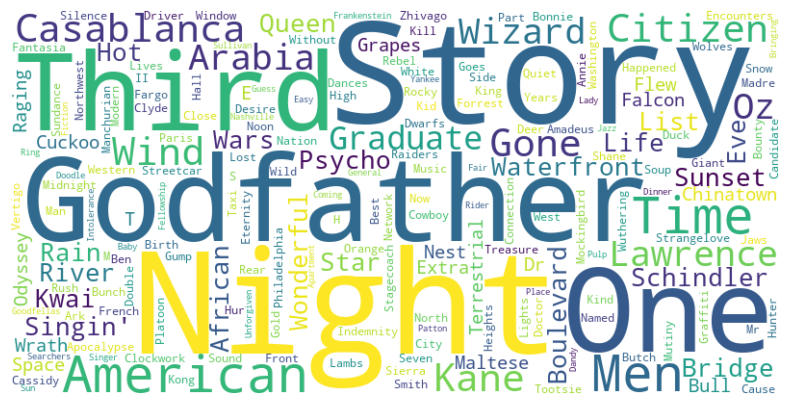

In [34]:
# word cloud for movie titles
# calculate word frequencies

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Film']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('title_wordcloud.png', dpi=300)

In [35]:
!pip install pymongo dnspython


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\MSI\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [36]:
from pymongo import MongoClient

# connect to local MongoDB
client = MongoClient('mongodb://localhost:27017/')

# Testing the connection
try:
    client.admin.command('ping')
    print("Connected to local MongoDB successfully!")
    
    # Create and access database
    db = client['mydatabase']
    
    # Create and access collection
    collection = db['mycollection']
    
    # Insert a test document
    collection.insert_one({"name": "Local MongoDB Test", "status": "Working"})
    
    print("Test document inserted successfully!")
except Exception as e:
    print(f"Connection failed: {e}")
    
  

Connected to local MongoDB successfully!
Test document inserted successfully!


In [37]:
# Connect to local MongoDB
client = MongoClient('mongodb://localhost:27017/') 

# Create and access database named 'movie_database'
db = client['movie_database'] 

# Create and access collection named 'afi_top_100'
collection = db['afi_top_100']  

# Convert DataFrame to dictionary and insert into MongoDB
records = df.to_dict('records')
collection.insert_many(records)

# Each DataFrame row becomes a MongoDB document
print(f"\nSuccessfully inserted {len(records)} documents into MongoDB!")

# Automatic _id field added 
# Data types are preserved 

# Print sample of the data from MongoDB
print("\n=== Sample from MongoDB ===")
for doc in collection.find().limit(5):  # first 5 documents
    print(doc)





Successfully inserted 123 documents into MongoDB!

=== Sample from MongoDB ===
{'_id': ObjectId('6814fe434bf0bd0dcd8f4185'), 'Film': 'Citizen Kane', 'Release year': 1941, 'Director': 'Orson Welles', 'Production companies': 'RKO Radio Pictures', '1998 Rank': '1', '2007 Rank': '1', 'Decade': 1940}
{'_id': ObjectId('6814fe434bf0bd0dcd8f4186'), 'Film': 'Casablanca', 'Release year': 1942, 'Director': 'Michael Curtiz', 'Production companies': 'Warner Bros. Pictures', '1998 Rank': '2', '2007 Rank': '3', 'Decade': 1940}
{'_id': ObjectId('6814fe434bf0bd0dcd8f4187'), 'Film': 'The Godfather', 'Release year': 1972, 'Director': 'Francis Ford Coppola', 'Production companies': 'Paramount Pictures, Alfran Productions', '1998 Rank': '3', '2007 Rank': '2', 'Decade': 1970}
{'_id': ObjectId('6814fe434bf0bd0dcd8f4188'), 'Film': 'Gone with the Wind', 'Release year': 1939, 'Director': 'Victor Fleming', 'Production companies': 'Selznick International Pictures', '1998 Rank': '4', '2007 Rank': '6', 'Decade': 1